In [79]:
import os
os.chdir("/")
! dir



bin	 dev   lib32  NGC-DL-CONTAINER-LICENSE	root		srv    usr
boot	 etc   lib64  opt			run		sys    var
content  home  media  proc			saved_model.h5	tmp
datalab  lib   mnt    python-apt		sbin		tools


In [80]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense


from sklearn.preprocessing import MinMaxScaler

In [81]:
file_name = "/content/drive/MyDrive/Colab Notebooks/NSE-Tata-Global-Beverages-Limited.csv"

In [82]:
df=pd.read_csv(file_name)
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


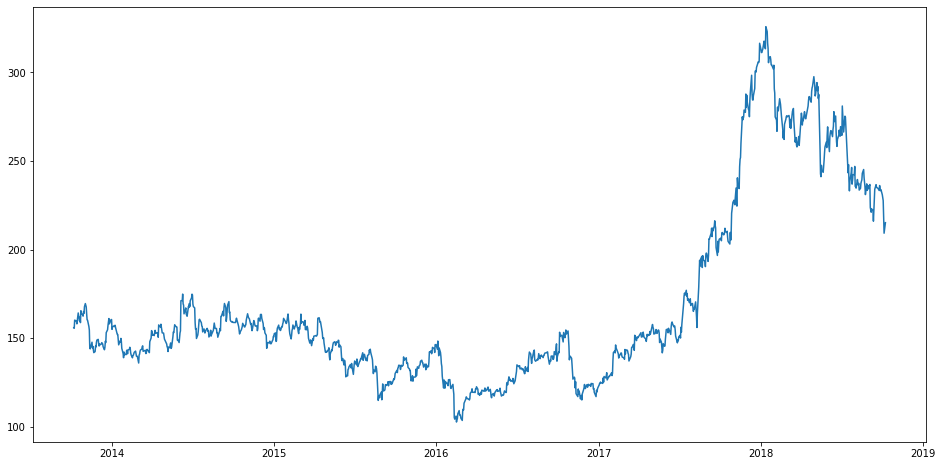

In [83]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [84]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

In [85]:

new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

In [86]:
new_dataset.index


DatetimeIndex(['2013-10-08', '2013-10-09', '2013-10-10', '2013-10-11',
               '2013-10-14', '2013-10-15', '2013-10-17', '2013-10-18',
               '2013-10-21', '2013-10-22',
               ...
               '2018-09-24', '2018-09-25', '2018-09-26', '2018-09-27',
               '2018-09-28', '2018-10-01', '2018-10-03', '2018-10-04',
               '2018-10-05', '2018-10-08'],
              dtype='datetime64[ns]', name='Date', length=1235, freq=None)

In [87]:
new_dataset.head()


,Close
Date,
2013-10-08,155.8
2013-10-09,155.55
2013-10-10,160.15
2013-10-11,160.05
2013-10-14,159.45


In [88]:
scaler=MinMaxScaler(feature_range=(0,1))
final_dataset=new_dataset.values
train_data=final_dataset[0:987,:]
valid_data=final_dataset[987:,:]
#

In [89]:
 scaler=MinMaxScaler(feature_range=(0,1))


In [90]:
scaled_data=scaler.fit_transform(final_dataset)
x_train_data,y_train_data=[],[]
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    

In [91]:

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))


In [92]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

927/927 - 27s - loss: 0.0013 - 27s/epoch - 29ms/step


In [93]:
lstm_model.save("saved_model.h5")


In [94]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

8/8 [==============================] - 1s 20ms/step


<ipython-input-95-397e778e3e61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


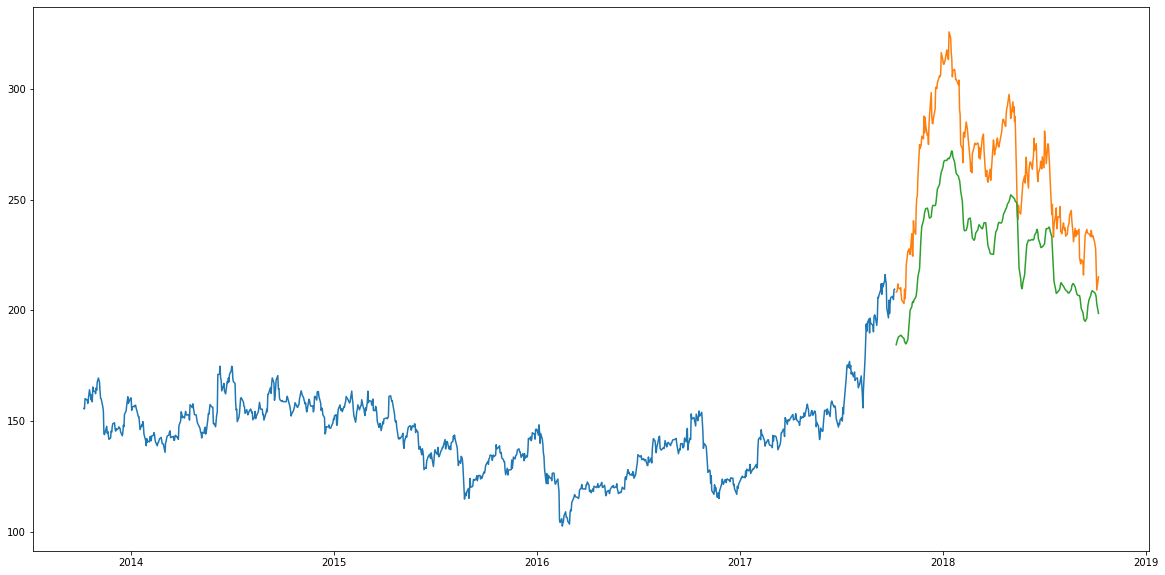

In [95]:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])